# Calculate CSDI: Cold-spell duration index

## Cold-spell duration index using the Copernicus Change Service (C3S)

### About

This tutorial will demonstrate how to calculate a climate index using a specific climate indices package. The example provided is of the Cold-spell duration index, but similar principles can be applied to many other types of single or multi-variable indices available in the icclim package.

The data is provided by Copernicus Climate Change Service (C3S) and includes daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations (E-OBS) of maximum temperature, minimum temperature, and precipitation.

The tutorial will first show how to download the necessary data from the C3S Climate Data Store (CDS). It will then describe how to calculate the Cold-spell duration index, and finally plot a map of the Cold-spell duration index climatology over Europe.

The steps shown in this tutorial can be applied to other climate datasets with the proper variable to calculate specific climate indices. For the current index, Cold-spell duration index, the Daily Minimum Temperature is needed.

### How to access the notebook

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/).

|NBViewer|
|:-:|
[![NBViewer](https://raw.githubusercontent.com/ecmwf-projects/copernicus-training/master/img/nbviewer_badge.svg)](https://nbviewer.org/github/cerfacs-globc/copernicus-training/blob/master/C3S_climate-indices_icclim.ipynb)|
|(this will not run the notebook, only render it)|

To run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which contains most of the libraries you will need.
You also need at least python version 3.8 for this notebook to work because of some requirements from some packages. 

You will need to install [icclim](https://github.com/cerfacs-globc/icclim) (`%pip install icclim`) for calculating the climate indices, and the CDS API (`%pip install cdsapi`) for downloading data programatically from the CDS. You will also need to install matplotlib (`%pip install matplotlib`) and cartopy (`%conda install cartopy`) to enable plotting of the results. The % character is to ensure installation occurs in your environment. The installation of cartopy requires a conda environment, if not already installed.

## Search, download and view data

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### Install CDS API

To install the CDS API, run the following command if not already installed in your environment.

In [1]:
%pip install cdsapi

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 13.6 MB/s eta 0:00:00
  Created wheel for cdsapi: filename=cdsapi-0.6.1-py2.py3-none-any.whl size=12008 sha256=e799f784cb58986da46ff3acf770b584483ef3236654524dbc1952d5839874bb
  Stored in directory: /home/bzah/.cache/pip/wheels/f9/26/57/a49a681496dea59363312ae87ffa8397100f8e8f6bab3591ea
Successfully built cdsapi
Note: you may need to restart the kernel to use updated packages.


### Install icclim

To install icclim, run the following command if not already installed in your environment.

In [5]:
%pip install icclim

Note: you may need to restart the kernel to use updated packages.


### Install matplotlib and cartopy

To install matplotlib and cartopy to enable plotting, run the following command if not already installed in your environment.
A conda environment is expected as cartopy cannot be correctly installed with pip.

In [3]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
%conda install -y cartopy

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::libcurl==8.5.0=hca28451_0
  - conda-forge/linux-64::libedit==3.1.20191231=he28a2e2_2
  - conda-forge/linux-64::netcdf4==1.6.5=nompi_py311he8ad708_100
  - conda-forge/linux-64::proj==9.3.1=h1d62c97_0
  - conda-forge/linux-64::libarrow-substrait==14.0.1=h61ff412_10_cpu
  - conda-forge/noarch::dask==2023.12.1=pyhd8ed1ab_0
  - conda-forge/linux-64::libarrow-flight==14.0.1=h120cb0d_10_cpu
  - conda-forge/linux-64::libarrow-dataset==14.0.1=h59595ed_10_cpu
  - conda-forge/linux-64::hdf5==1.14.3=nompi_h4f84152_100
  - conda-forge/linux-64::krb5==1.21.2=h659d440_0
  - conda-forge/linux-64::libarrow-gandiva==14.0.1=hacb8726_10_cpu
  - conda-forge/linux-64::pyarrow==14.0.1=py311h39c9aba_10_cpu
  - conda-forge/linux-64::libcups==2.3.3=h4637d8d_4
  - conda-forge/linux-64::libnetcdf==4.9.2=nompi_h9612171_113
  - conda-forge/

### Import libraries

We will be working with data in NetCDF format and calculating climate indices. We will use the icclim package and its dependencies for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [1]:
import sys

import cartopy.crs as ccrs

# CDS API
import cdsapi

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt

# Libraries for working with multidimensional arrays
import numpy as np

# Disable warnings for data download via API
import urllib3
import xarray as xr

# icclim package for calculating climate indices
import icclim

# To add specific units spelling

urllib3.disable_warnings()

# To unzip dataset files from the CDS
from zipfile import ZipFile

import dask

# Dask

In [2]:
print("python: ", sys.version)
print("numpy: ", np.__version__)
print("xarray: ", xr.__version__)
print("icclim: ", icclim.__version__)
print("dask: ", dask.__version__)

python:  3.11.7 | packaged by conda-forge | (main, Dec 15 2023, 08:38:37) [GCC 12.3.0]
numpy:  1.26.2
xarray:  2023.10.1
icclim:  6.6.0
dask:  2023.12.1


### Enter your CDS API key

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.

In [3]:
URL = "https://cds.climate.copernicus.eu/api/v2"
KEY = "118084:b3d0c1de-08ba-49d2-9f26-9bf464cd87ba"

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [4]:
DATADIR = "./data"

### Search for climate data to calculate the Cold-spell duration index

The Cold-spell duration index we will calculate takes one parameter as input, it is the daily minimum temperature. Data for this parameter is available as part of the E-OBS daily gridded meteorological data for Europe from 1950 to present, but we will select a shorter period so that the download is faster: we will select the period from 2011 to 2021. We will search for this data on the CDS website: http://cds.climate.copernicus.eu. The specific dataset we will use is the `E-OBS daily gridded meteorological data for Europe from 1950 to present derived from in-situ observations`. 

Having selected the dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Product type: `Ensemble mean`
- Variable: `Minimum temperature`
- Grid resolution: `0.1deg`
- Period: `2011_2021`
- Version: `25.0e` (Latest version)
- Format: `Zip file (.zip)`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cells below). You will do this once for Minimum temperature.

### Download data

... having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the **terms and conditions** of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **"Show API request"** option.

In [18]:
c = cdsapi.Client(url=URL, key=KEY)

# For the full period, use period: 'full_period' but it takes a long time to download data
# To download last decade use 'period': '2011_2021',

c.retrieve(
    "insitu-gridded-observations-europe",
    {
        "format": "zip",
        "product_type": "ensemble_mean",
        "variable": "minimum_temperature",
        "grid_resolution": "0.1deg",
        "period": "2011_2021",
        "version": "25.0e",
    },
    f"{DATADIR}/eobs_tasmin.zip",
)

2024-01-22 11:33:46,264 INFO Welcome to the CDS
2024-01-22 11:33:46,264 Welcome to the CDS
2024-01-22 11:33:46,267 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-europe
2024-01-22 11:33:46,267 Sending request to https://cds.climate.copernicus.eu/api/v2/resources/insitu-gridded-observations-europe
2024-01-22 11:33:46,394 INFO Request is completed
2024-01-22 11:33:46,394 Request is completed
2024-01-22 11:33:46,396 INFO Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data5/dataset-insitu-gridded-observations-europe-7854fb4f-0ba3-450f-ba4b-916089cafeba.zip to ./data/eobs_tasmin.zip (752.4M)
2024-01-22 11:33:46,396 Downloading https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data5/dataset-insitu-gridded-observations-europe-7854fb4f-0ba3-450f-ba4b-916089cafeba.zip to ./data/eobs_tasmin.zip (752.4M)
2024-01-22 11:34:54,570 INFO Download rate 11M/s                          

Result(content_length=788898271,content_type=application/zip,location=https://download-0011-clone.copernicus-climate.eu/cache-compute-0011/cache/data5/dataset-insitu-gridded-observations-europe-7854fb4f-0ba3-450f-ba4b-916089cafeba.zip)

### Inspect Data

We have requested the data in a zip archive. This zip archive contains a file in the NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the underlying Xarray library that is used by the software to calculate the climate index. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will uncompress the archive and retrieve the filename(s). The archive could contain several files, but since we requested only one time period, we have a list of one file.

In [5]:
# Create a ZipFile Object and load eobs_pr.zip in it
with ZipFile(f"{DATADIR}/eobs_tasmin.zip", "r") as zipObj:
    # Get a list of all archived file names from the zip
    listOfFileNames = zipObj.namelist()
    # Extract all the contents of zip file in current directory
    zipObj.extractall()

# List the NetCDF filenames of the dataset
print(listOfFileNames)

['tn_ens_mean_0.1deg_reg_2011-2021_v25.0e.nc']


## Calculate Cold-spell duration index using icclim

Let's calculate the Cold-spell duration index (CSDI) function using the [icclim](https://icclim.readthedocs.io/en/stable/) software. We retrieve the calculated values in an Xarray dataset, but alternatively we could also write the values automatically in an output NetCDF file using the keyword out_file when calling the icclim function.

In [ ]:
# Add out_file='out_icclim.nc' to also output data into a NetCDF file
csdi = icclim.csdi(in_files=listOfFileNames[0], slice_mode="year")

Before we plot the results, we can query our newly created Xarray dataset ...

In [10]:
csdi

<xarray.Dataset>
Dimensions:      (time: 11, longitude: 705, latitude: 465, bounds: 2)
Coordinates:
  * time         (time) datetime64[ns] 2011-07-02 ... 2021-07-02
  * longitude    (longitude) float64 -24.95 -24.85 -24.75 ... 45.25 45.35 45.45
  * latitude     (latitude) float64 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * bounds       (bounds) int64 0 1
Data variables:
    CSDI         (time, latitude, longitude) float64 dask.array<chunksize=(1, 93, 141), meta=np.ndarray>
    time_bounds  (time, bounds) datetime64[ns] 2011-01-01 ... 2021-12-31
Attributes:
    title:        cold index CSDI
    references:   ATBD of the ECA&D indices calculation (https://knmi-ecad-as...
    institution:  Climate impact portal (https://climate4impact.eu)
    history:      Mon Mar 28 11:53:26 2022: ncks --no-abc -d time,22280,26297...
    source:       
    Conventions:  CF-1.6

We see that csdi (dataset for the Cold-spell duration index) has one variable called "CSDI". If you view the documentation of [icclim](https://icclim.readthedocs.io/en/stable/explanation/climate_indices.html) you will see that this is the Cold-spell duration index valid for a grid cell at the surface. The units are days.

While an Xarray dataset may contain multiple variables, an Xarray data array holds a single multi-dimensional variable and its coordinates.

Now let's plot the average Cold-spell duration index for this time over Europe, and we take the same European subset as that used for the [C3S Climate Bulletins](https://climate.copernicus.eu/climate-bulletins).

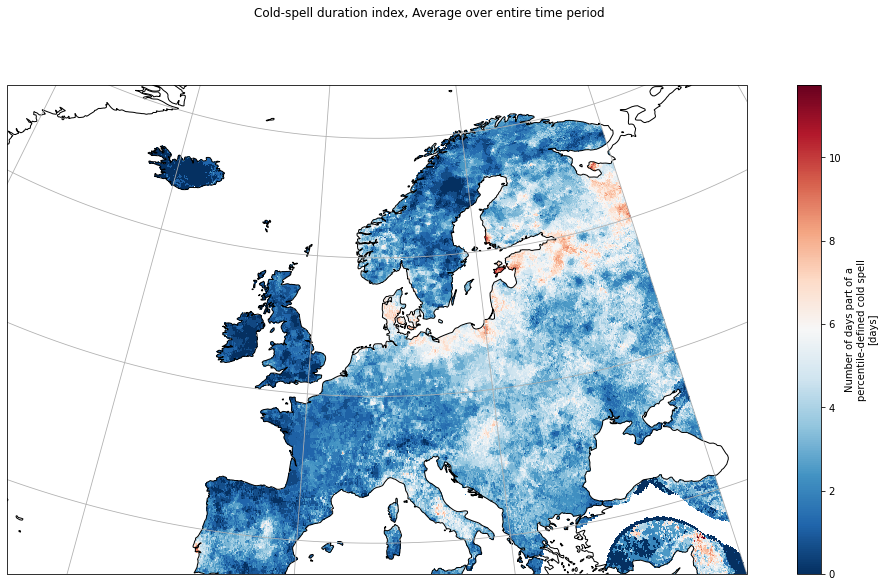

In [11]:
# Set spatial extent and centre
central_lat = 53.0
central_lon = 7.5
extent = [-25, 40, 34, 72]  # Western Europe

# Calculate time average
csdi_avg = csdi["CSDI"].mean(dim="time", keep_attrs=True)

# Select European subset
csdi_sub = csdi_avg.where(
    (csdi_avg.latitude < 72)
    & (csdi_avg.latitude > 34)
    & (csdi_avg.longitude < 40)
    & (csdi_avg.longitude > -25),
    drop=True,
)

# Set plot projection
map_proj = ccrs.AlbersEqualArea(
    central_longitude=central_lon, central_latitude=central_lat
)

# Define plot
f, ax = plt.subplots(figsize=(18, 9), subplot_kw={"projection": map_proj})

# Plot data with proper colormap scale range
# levels = np.arange(0, 1.0, 0.1)
p = csdi_sub.plot(cmap="RdBu_r", transform=ccrs.PlateCarree())

# Plot information
plt.suptitle("Cold-spell duration index, Average over entire time period", y=1)

# Add the coastlines to axis and set extent
ax.coastlines()
ax.gridlines()
ax.set_extent(extent)

# Save plot as png
plt.savefig(f"{DATADIR}E-OBS_csdi_index.png")

The cold spell durations is quite uniform in Europe, and maximum can be seen in Denmark and near the southern coast of the Black Sea.

<hr>